# 概要

* 計算物理学入門のP223～P230に掲載されているプログラム md をPythonで再現するためのファイル


In [1]:
import sys
import time
import matplotlib.pyplot as plt

In [2]:
# 変数の宣言

x = [0] * 16
y = [0] * 16
vx = [0] * 16
vy = [0] * 16
ax = [0] * 16
ay = [0] * 16

N = 0
Lx = 0
Ly = 0
dt = 0
dt2 = 0

gcum = []
for i in range(1000):
    gcum.append(i)
nbin = 0
dr = 0
xsave = [0] * 100
ysave = [0] * 100
R2cum = [0] * 100

# 変数の宣言２(グローバルで扱ったほうが良いものを追加している)
t = 0
ke = 0
kecum = 0
pecum = 0
vcum = 0
area = 0
pbc = 0

pe = 0
virial = 0

dx = 0
dy = 0
fx = 0
fy = 0
fxij = 0
fyij = 0
pot = 0

In [3]:
def initial():
    global pbc
    abc = 0
    global dt
    dt = 0.01
    global dt2
    dt= dt * dt
    
    response = ""
    global N
    N = 16
    global Lx
    Lx = 6
    global Ly
    Ly = 6
    
    DATA = [
        1.09,0.98,-0.33,0.78,3.12,5.25,0.12,-1.19
      , 0.08,2.38,-0.08,-0.10,0.54,4.08,-1.94,-0.56
      , 2.52,4.39,0.75,0.34,3.03,2.94,1.70,-1.08
      , 4.25,3.01,0.84,0.47,0.89,3.11,-1.04,0.06
      , 2.76,0.31,1.64,1.36,3.14,1.91,0.38,-1.24
      , 0.23,5.71,-1.58,0.55,1.91,2.46,-1.55,-0.16
      , 4.77,0.96,-0.23,-0.83,5.10,4.63,-0.31,0.65
      , 4.97,5.88,1.18,1.48,3.90,0.20,0.46,-0.51
    ]
    
    global x
    global y
    global vx
    global vy
    
    for i in range(N):
        x[i] = DATA[4*i+0]
        y[i] = DATA[4*i+1]
        vx[i] = DATA[4*i+2]
        vy[i] = DATA[4*i+3]
    
    global ke
    ke = 0
    for i in range(N):
        ke = ke + vx[i]* vx[i] + vy[i]* vy[i]
    ke = 0.5 * ke
    global area
    area = Lx * Ly
    global t
    t = 0
    global kecum
    kecum = 0
    global pecum
    pecum = 0
    global vcum
    vcum = 0    

In [4]:
def separation(ds, L):
    if (ds > 0.5 * L):
        return ds - L
    elif (ds < -0.5 * L):
        return ds + L
    else:
        return ds

In [5]:
def force():
    global dx
    global dy
    global fxij
    global fyij
    global pot
    r2 = dx*dx + dy*dy
    rm2 = 1/r2
    rm6 = rm2 * rm2 * rm2
    f_over_r = 24 * rm6 * (2 * rm6 - 1) * rm2
    fxij = f_over_r * dx
    fyij = f_over_r * dy
    pot = 4 * (rm6 * rm6 - rm6)

In [6]:
def accel():
    global pe
    pe = 0
    global virial
    virial = 0
    global N
    global x
    global y
    global Lx
    global Ly
    global ax
    global ay
    global dx
    global dy
    global pot
    
    for i in range(N):
        ax[i] = 0
        ay[i] = 0
    
    for i in range(N-1):
        for j in range(i+1, N):
            dx = separation(x[i] - x[j], Lx)
            dy = separation(y[i] - y[j], Ly)
            force()
            ax[i] = ax[i] + fxij
            ay[i] = ay[i] + fyij
            ax[j] = ax[j] - fxij
            ay[j] = ay[j] - fyij
            pe = pe + pot
            virial = virial + dx*fxij + dy*fyij
            

In [7]:
def pbc(pos, L):
    if (pos < L):
        return (pos+L)
    elif(pos > L):
        return (pos-L)
    else:
        return (pos)
    

In [8]:
def Verlet():
    global x
    global y
    global vx
    global vy
    global ax
    global ay
    global N
    global Lx
    global Ly
    global dt
    global dt2
    global ke
    global t
    
    for i in range(N):
        xnew = x[i] + vx[i] * dt + 0.5 * ax[i] * dt2
        ynew = y[i] + vy[i] * dt + 0.5 * ay[i] * dt2
        vx[i] = vx[i] + 0.5 * ax[i] * dt
        vy[i] = vy[i] + 0.5 * ay[i] * dt
        x[i] = pbc(xnew, Lx)
        y[i] = pbc(ynew, Ly)
        
    accel()
        
    ke = 0
    for i in range(N):
        vx[i] = vx[i] + 0.5 * ax[i] * dt
        vy[i] = vy[i] + 0.5 * ay[i] * dt
        ke = ke + vx[i] * vx[i] + vy[i] * vy[i]
        ke = 0.5 * ke
        t = t + 1

In [9]:
def show_output():
    global t
    global ke
    global pe
    global virial
    global kecum
    global vcum
    global ncum
    global area
    global N
    global Lx
    global Ly

    print_str = ""
    print_str += "ncum:"+str(ncum)
    print_str += ", t:"+str(t)
    E = ke + pe
    print_str += ", E:"+'{}'.format(E)
    kecum = kecum + ke
    vcum = vcum + virial
    mean_ke = kecum / ncum
    p = mean_ke + (0.5 * vcum) / ncum
    p = p / area
    print_str += ", mean_ke/N:"+'{:.3E}'.format(mean_ke/N)
    print_str += ", p:"+'{:.3E}'.format(p)
    
    print_str += ", ke:"+'{}'.format(ke)
    print_str += ", pe:"+'{}'.format(pe)
    
    print(print_str)
    


ncum:10000, t:160000, E:-12.229233133145517, mean_ke/N:8.907E-06, p:4.279E-05, ke:1.4251978931175175, pe:-13.654431026263033
ncum:20000, t:320000, E:-12.621066304530801, mean_ke/N:1.061E-05, p:3.818E-05, ke:1.9688546878217534, pe:-14.589920992352555
ncum:30000, t:480000, E:-16.62466907774046, mean_ke/N:1.063E-05, p:4.956E-05, ke:1.7066571502579948, pe:-18.331326227998456
ncum:40000, t:640000, E:-7.61060020816636, mean_ke/N:1.037E-05, p:1.032E-04, ke:1.5333208623458607, pe:-9.14392107051222
ncum:50000, t:800000, E:-15.404024901738293, mean_ke/N:1.001E-05, p:7.677E-05, ke:1.3747177466624236, pe:-16.778742648400716
ncum:60000, t:960000, E:-12.17985977969237, mean_ke/N:1.298E-05, p:6.636E-05, ke:4.4494354659602156, pe:-16.629295245652585
ncum:70000, t:1120000, E:-13.998068659130457, mean_ke/N:1.431E-05, p:5.599E-05, ke:3.5704441934787607, pe:-17.568512852609217
ncum:80000, t:1280000, E:-15.953780138512911, mean_ke/N:1.410E-05, p:4.482E-05, ke:2.015795395293634, pe:-17.969575533806545
ncum:

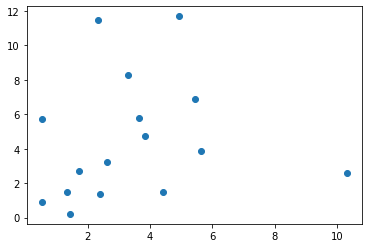

ncum:110000, t:1760000, E:-14.45118691631364, mean_ke/N:1.393E-05, p:5.326E-05, ke:0.6726709351747076, pe:-15.123857851488347


In [10]:
initial()
accel()
E = ke + pe
ncum = 0
flag = True
while (t <= 1760000):
#     show_positions(flag)
    Verlet()
    ncum = ncum + 1
    if(ncum % 10000 == 0):
        show_output()
    if(ncum % 100000 == 0):
        plt.scatter(x, y)
        print(f"x:{x}")
        print(f"y:{y}")
#         print(f"vx:{vx}")
#         print(f"vy:{vy}")
        plt.show()
        